## About
Binary image segmentation using a U-net to predict where the car is in the image.

## Setup

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import pathlib
import torch

In [3]:
import fastai
from fastai.vision import *
#from fastai.callbacks import *

## Data
- Download dataset
- Visualize sample image and mask

In [4]:
path = pathlib.Path.home()/'.fastai/data/carvana-image-masking-challenge'

In [5]:
! mkdir -p $path;
! kaggle competitions download -c carvana-image-masking-challenge -f train.zip -p $path
! kaggle competitions download -c carvana-image-masking-challenge -f train_masks.zip -p $path
! kaggle competitions download -c carvana-image-masking-challenge -f train_masks.csv.zip -p $path
! kaggle competitions download -c carvana-image-masking-challenge -f test.zip -p $path

! cd $path; if [ ! -d train ]; then unzip -n -q train.zip; fi
! cd $path; if [ ! -d train_masks ]; then unzip -n -q train_masks.zip; fi
! cd $path; if [ ! -f train_masks.csv ]; then unzip -n -q train_masks.csv.zip; fi
! cd $path; if [ ! -d test ]; then unzip -n -q test.zip; fi

train.zip: Skipping, found more recently modified local copy (use --force to force download)
train_masks.zip: Skipping, found more recently modified local copy (use --force to force download)
train_masks.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
os.listdir(path)

['metadata.csv.zip',
 'train_masks.zip',
 'train_masks.csv.zip',
 'sample_submission.csv.zip',
 'test.zip',
 '29bb3ece3180_11.jpg',
 'train',
 'test',
 'train_masks',
 'train_masks.csv',
 'metadata.csv',
 'sample_submission.csv',
 'train.zip',
 'train_224',
 'train_224_masks',
 'submission.csv']

In [7]:
os.listdir(path/'train')[:5]

['00087a6bd4dc_01.jpg',
 '00087a6bd4dc_02.jpg',
 '00087a6bd4dc_03.jpg',
 '00087a6bd4dc_04.jpg',
 '00087a6bd4dc_05.jpg']

In [8]:
img_path = path/'train/00087a6bd4dc_01.jpg'

In [9]:
img = open_image(img_path)

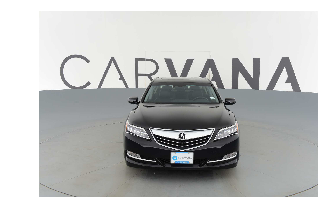

In [10]:
img.show(figsize=(5,5))

In [11]:
img.shape

torch.Size([3, 1280, 1918])

In [12]:
os.listdir(path/'train_masks')[:5]

['00087a6bd4dc_01_mask.gif',
 '00087a6bd4dc_02_mask.gif',
 '00087a6bd4dc_03_mask.gif',
 '00087a6bd4dc_04_mask.gif',
 '00087a6bd4dc_05_mask.gif']

In [13]:
def get_y_fn(x):
    fname = str(x.name).replace('.jpg', '_mask.gif')
    return Path(str(x.parent)+f'_masks/{fname}')

In [14]:
mask = open_mask(get_y_fn(img_path))

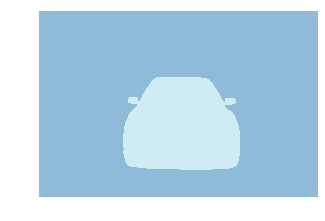

In [15]:
mask.show(figsize=(5,5))

In [16]:
mask.shape

torch.Size([1, 1280, 1918])

## Datasets

In [17]:
bs = 16
num_workers = 6
size = 224

In [18]:
tfms = get_transforms()

In [19]:
# need custom class to set div=True so classes are [0,1] instead of [0,256]
class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn):
        return open_mask(fn, div=True)
    
class SegItemListCustom(SegmentationItemList):
    _label_cls = SegLabelListCustom

In [20]:
fake_label = path/'train_masks/00087a6bd4dc_01_mask.gif'

In [21]:
src = (SegItemListCustom.from_folder(path/'train')
        .split_by_rand_pct(valid_pct=0.30)
        .label_from_func(get_y_fn, classes=['no', 'yes'])
        .add_test_folder('../test', label=fake_label))

In [22]:
data = (src.transform(tfms, size=size, tfm_y=True)
        .databunch(bs=bs, num_workers=num_workers)
        .normalize(imagenet_stats))

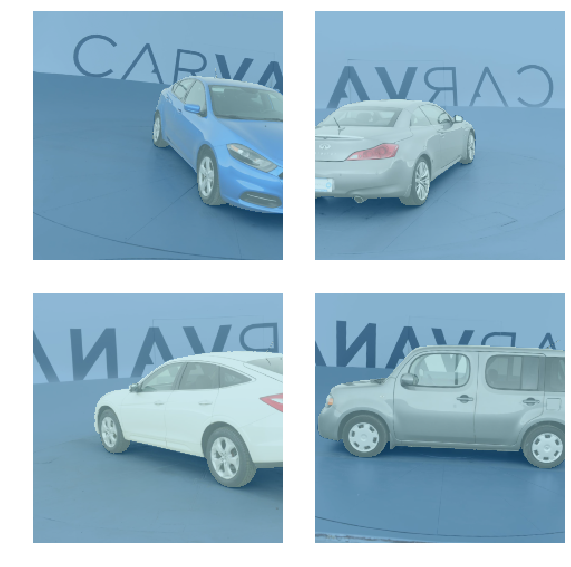

In [23]:
data.show_batch(2, fig_size=(5,5))

In [24]:
data.train_ds

LabelList (3562 items)
x: SegItemListCustom
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: SegLabelListCustom
ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224)
Path: /root/.fastai/data/carvana-image-masking-challenge/train

In [25]:
data.valid_ds

LabelList (1526 items)
x: SegItemListCustom
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: SegLabelListCustom
ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224)
Path: /root/.fastai/data/carvana-image-masking-challenge/train

In [26]:
data.test_ds

LabelList (100064 items)
x: SegItemListCustom
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: SegLabelListCustom
ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224)
Path: /root/.fastai/data/carvana-image-masking-challenge/train

In [27]:
data.c

2

## Model

In [28]:
arch = models.resnet34
wd=1e-2

In [29]:
learn = unet_learner(data, arch, metrics=[dice], wd=wd)

In [30]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
ReLU                 [64, 56, 56]         0          False     
______________________________________________________________

## Train

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


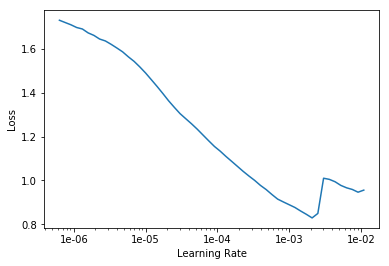

In [31]:
learn.lr_find()
learn.recorder.plot()

In [32]:
lr = 2e-4

In [33]:
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,dice,time
0,0.067395,0.043196,0.969938,03:13
1,0.026814,0.021653,0.985594,03:23
2,0.017919,0.018541,0.987320,03:19
3,0.015492,0.016408,0.988868,03:15
4,0.013192,0.011722,0.991982,03:16
5,0.012074,0.011069,0.992424,03:03
6,0.011229,0.010670,0.992662,03:03
7,0.010076,0.009962,0.993138,02:55
8,0.009673,0.009419,0.993524,02:59
9,0.009374,0.009342,0.993574,02:56


In [34]:
learn.save('stage-1')

In [35]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


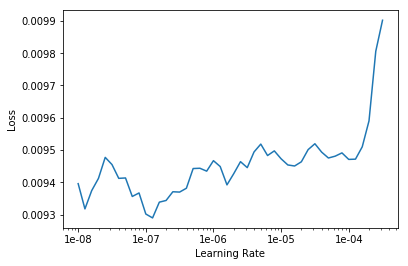

In [37]:
learn.lr_find(start_lr=1e-9)
learn.recorder.plot()

In [38]:
learn.fit_one_cycle(10, max_lr=slice(2e-6, 2e-5))

epoch,train_loss,valid_loss,dice,time
0,0.009427,0.009323,0.993588,03:07
1,0.009524,0.009272,0.993639,03:03
2,0.009515,0.009205,0.993692,02:52
3,0.009208,0.009100,0.993728,02:59
4,0.009215,0.008909,0.993864,03:01
5,0.008977,0.008898,0.993879,02:55
6,0.008888,0.008796,0.993950,03:01
7,0.008858,0.008732,0.993994,02:56
8,0.008710,0.008695,0.994022,02:58
9,0.008682,0.008693,0.994025,03:09


In [39]:
learn.save('stage-2')

## Results

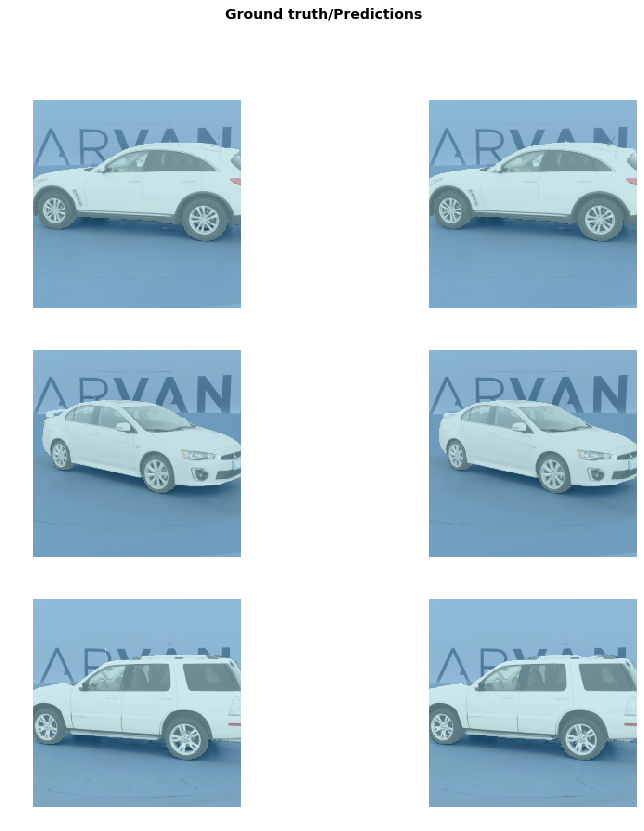

In [40]:
learn.show_results(rows=3, figsize=(13,13))

## Submission

In [ ]:
#preds, _ = learn.get_preds()
preds, _ = learn.get_preds(DatasetType.Test)

In [ ]:
submission = pd.read_csv(path/'sample_submission.csv', index_col='img')

In [ ]:
submission.head()

In [ ]:
# convert preds into submission
# assumes test set ordered same as sample submission file
for i, pred in enumerate(preds):
    # convert to ndarray
    pred = pred.argmax(dim=0).cpu().detach().to(torch.uint8).numpy()
    # resize to full image size
    pred = np.resize(pred, (1280, 1918))
    # generate run length encoding
    pred = rle_encode(pred)
    # update submission dataframe
    submission.iloc[i] = pred

In [ ]:
submission.head()

In [ ]:
submission_file = path/'submission.csv'
submission.to_csv(submission_file)

In [ ]:
# submit to leaderboard
#! cd $path; kaggle competitions submit -c carvana-image-masking-challenge -f $submission_file -m "my_submission"

#### TODOs
- split test dataset.  can't store predictions on 100,000 items.